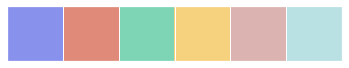

In [1]:
import pickle5 as pickle
import json
from sklearn.metrics import ndcg_score
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(font_scale=1.5)
pd.set_option('display.max_rows', 999)

colors = sns.color_palette("Spectral", 10)
pal = [colors[9],colors[1], colors[7],colors[0],colors[3],colors[8],colors[2]]
pal_unnorm = [[136, 145, 235], [224, 139, 121], [125, 213, 181],
        [246, 210, 127], [219, 179, 176], [185, 224, 227], ]
pal = [[a/255,b/255,c/255] for a,b,c in pal_unnorm]
sns.palplot(pal)
from scipy import stats


In [2]:
def parse_data(data, condition, explanation_key):
    records = []
    for query in data:
        explanations = query[explanation_key]
        for explanation in explanations:
            ex_h1, ex_r1, ex_t1, ex_r2, ex_t2 = (np.nan,np.nan,np.nan,np.nan,np.nan)
            ex_h1 =  explanation['path'][0]
            ex_r1 =  explanation['path'][1]
            ex_t1 =  explanation['path'][2]
            
            if len(explanation['path'])>3:
                path_type = 'two_hop'
                ex_r2 =  explanation['path'][3]
                ex_t2 =  explanation['path'][4]
                hops = [(ex_h1, ex_r1, ex_t1), (ex_t1, ex_r2,ex_t2)]
            else:
                path_type = 'one_hop'
                hops = [(ex_h1, ex_r1, ex_t1)]
            
            if 'coef' in explanation:
                coef = explanation['coef']
                one_hop_score = explanation['kge_score']['1st_hop_kge_score']
                path_score = explanation['kge_score']['path_score']
            else:
                coef, one_hop_score, path_score = (np.nan, np.nan, np.nan)
            if 'split' in explanation:
                split = explanation['split']
            else:
                split = np.nan
            
            for index, hop in enumerate(hops):
                records.append({
                        'cond':condition,
                        'query_string': query['query_triple'][0] + '_has_parents_' + query['query_triple'][2],
                        'q_head': query['query_triple'][0],
                        'q_rel': query['query_triple'][1],
                        'q_tail': query['query_triple'][2],
                        'path_type': path_type,
                        'hop': index+1,
                        'ex_head': hop[0],
                        'ex_rel': hop[1],
                        'ex_tail': hop[2],
                        'coef':coef,
                        'first_hop_score': one_hop_score,
                        'path_score': path_score,                  
                        'split':split})
    return records

def pickle_to_data(experiment_path, conditions, experiments):
    results = {}
    results['no_sib'] = {}
    results['with_sib'] = {}
    for condition in conditions:
        for experiment in experiments:
            with open(f'{experiment_path}{experiment}_{condition}.pickle', 'rb') as f:
                results[experiment][condition] = pickle.load(f)
    records = []
    for expt in experiments:
        for cond in conditions:
            records.extend(parse_data(results[expt][cond], expt + '_' + cond, 'linklogic_explanations'))

    return pd.DataFrame(records)

def find_sibling_links_not_in_fb13(df):
    records = []
    for index, row in df[(df.ex_head==df.q_head) | (df.ex_tail==df.q_head)].iterrows():
        if row['link_exists']==0:
            if (row['ex_head']==row['q_head']) and (row['ex_tail'] in true_siblings[row['q_head']]):
                records.append(row.to_dict())
            elif (row['ex_tail']==row['q_head']) and (row['ex_head'] in true_siblings[row['q_head']]):
                records.append(row.to_dict())
    
    return pd.DataFrame(records)

def find_sibling_links_not_in_fb13_long(df, fb_data):
    records = []
    for index, row in df[(df.ex_head==df.q_head) | (df.ex_tail==df.q_head)].iterrows():
        fb_sub = fb_data[(fb_data.e1==row['q_head']) | (fb_data.e2==row['q_head'])]
        if (row['ex_head']==row['q_head']) and (row['ex_rel'] not in fb_sub.r) and (row['ex_tail'] in true_siblings[row['q_head']]):
            records.append(row.to_dict())
        elif (row['ex_tail']==row['q_head']) and (row['ex_rel'] not in fb_sub.r) and (row['ex_head'] in true_siblings[row['q_head']]):
            records.append(row.to_dict())
    
    return pd.DataFrame(records)

### Get that benchmark and siblings

In [3]:
data_dir = '../../data/pseudosib'
with open(f'{data_dir}/commonsense_benchmark_for_analysis.json', 'r') as f:
    benchmark = json.load(f)

with open(f'{data_dir}/siblings.json', 'r') as f:
    true_siblings = json.load(f)

name_type = pd.read_csv(f'{data_dir}/entity_names_to_types.csv')

b_df = pd.DataFrame(parse_data(benchmark, 'benchmark','explanatory_paths'))

In [4]:
b_df.head()

,cond,query_string,q_head,q_rel,q_tail,path_type,hop,ex_head,ex_rel,ex_tail,coef,first_hop_score,path_score,split
0,benchmark,ernst_hanfstaengl_has_parents_munich,ernst_hanfstaengl,location,munich,one_hop,1,ernst_hanfstaengl,place_of_birth,munich,NaN,NaN,NaN,NaN
1,benchmark,ernst_hanfstaengl_has_parents_munich,ernst_hanfstaengl,location,munich,one_hop,1,ernst_hanfstaengl,place_of_death,munich,NaN,NaN,NaN,NaN
2,benchmark,irene_doukaina_laskarina_has_parents_elena_of_...,irene_doukaina_laskarina,parents,elena_of_bulgaria,two_hop,1,irene_doukaina_laskarina,parents,theodore_ii_laskaris,NaN,NaN,NaN,NaN
3,benchmark,irene_doukaina_laskarina_has_parents_elena_of_...,irene_doukaina_laskarina,parents,elena_of_bulgaria,two_hop,2,theodore_ii_laskaris,spouse,elena_of_bulgaria,NaN,NaN,NaN,NaN
4,benchmark,irene_doukaina_laskarina_has_parents_elena_of_...,irene_doukaina_laskarina,parents,elena_of_bulgaria,one_hop,1,irene_doukaina_laskarina,parents,theodore_ii_laskaris,NaN,NaN,NaN,NaN


### Get that data

In [5]:
df_list = []
for split in ['train','valid','test']:   
    temp = pd.read_csv(f'{data_dir}/fb13_resplit/{split}.txt',sep='\t',names=['e1','r','e2'])
    temp['split']=split
    df_list.append(temp)
fb_13 = pd.concat(df_list)

In [6]:
fb_13.head()

,e1,r,e2,split
0,doris_duke,location,new_york,train
1,ioannis_metaxas,religion,eastern_orthodox_church,train
2,john_hill_1716,gender,male,train
3,matvey_kazakov,place_of_death,ryazan,train
4,william_h_pitsenbarger,place_of_birth,piqua,train


### Get those results

In [7]:
conditions = ['child_true','child_false']
experiments = ['no_sib','with_sib']

cond_order = ['no_sib_child_true','no_sib_child_false','with_sib_child_true','with_sib_child_false']

df_split = pickle_to_data(f'{data_dir}/rachel_results/', conditions, experiments)
df_full = pickle_to_data(f'{data_dir}/full_results/', conditions, experiments)

In [8]:
rel_emb_13 = np.load(f'{data_dir}/embeddings/fb_13/relation_embedding.npy')
rel_id_13 = pd.read_csv(f'{data_dir}/embeddings/fb_13/relation2id.txt', sep='\t', names=['rel','idx'])
rel_emb_14 = np.load(f'{data_dir}/embeddings/fb_14/relation_embedding.npy')
rel_id_14 = pd.read_csv(f'{data_dir}/embeddings/fb_14/relation2id.txt', sep='\t',names=['rel','idx'])

In [9]:
#df_split = df_split[df_split.q_head.isin(true_siblings)]
df_full = df_full[df_full.q_head.isin(true_siblings)]

In [10]:
df = df_full
df = df.merge(fb_13, left_on=['ex_head','ex_rel','ex_tail'], right_on=['e1','r','e2'], how='left')
df.loc[~pd.isnull(df.e1), 'link_exists']=1
df.drop(columns=['split_x','e1','r','e2'], inplace=True)
df.rename(columns={'split_y':'split'}, inplace=True)
df.fillna(0,inplace=True)

##### Question: what are the relations involved when predicting the parent over conditions?

<Figure size 1440x576 with 0 Axes>

[Text(0, 0, 'children'),
 Text(0, 0, 'parents'),
 Text(0, 0, 'sibling'),
 Text(0, 0, 'spouse'),
 Text(0, 0, 'place_of_birth'),
 Text(0, 0, 'place_of_death'),
 Text(0, 0, 'location'),
 Text(0, 0, 'institution'),
 Text(0, 0, 'cause_of_death'),
 Text(0, 0, 'religion'),
 Text(0, 0, 'profession'),
 Text(0, 0, 'ethnicity'),
 Text(0, 0, 'nationality')]

Text(0, 0.5, 'Prevalance (# incidents)')

Text(0.5, 0, 'Relation')

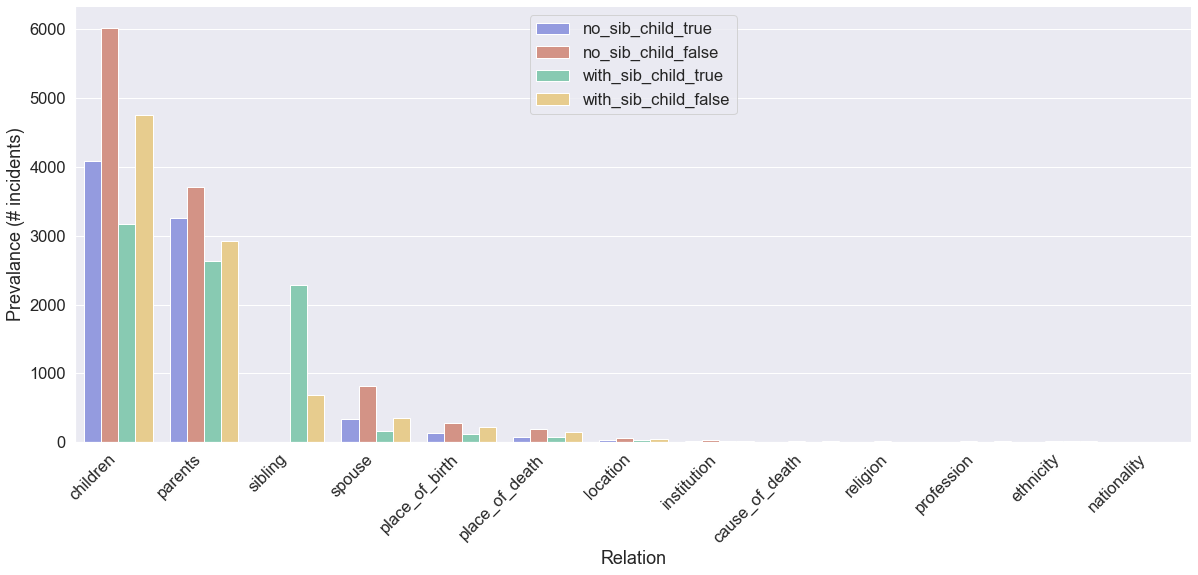

In [11]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x = "ex_rel", y="q_head", hue="cond",palette=pal,
    data = df[df.path_type=='one_hop'].groupby(['cond','ex_rel']).count().sort_values(by=['cond']).sort_values(
        by=['coef'], ascending=False).reset_index(), hue_order = cond_order)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('Prevalance (# incidents)')
ax.set_xlabel('Relation')
plt.legend(title='')
sns.despine()

<Figure size 1440x432 with 0 Axes>

[Text(0, 0, 'sibling'),
 Text(0, 0, 'spouse'),
 Text(0, 0, 'children'),
 Text(0, 0, 'parents')]

Text(0, 0.5, 'Prevalance (# incidents)')

Text(0.5, 0, 'Relation')

Text(0.5, 1.0, 'Hop 1')

[Text(0, 0, 'parents'),
 Text(0, 0, 'children'),
 Text(0, 0, 'spouse'),
 Text(0, 0, 'sibling')]

Text(0, 0.5, 'Prevalance (# incidents)')

Text(0.5, 0, 'Relation')

Text(0.5, 1.0, 'Hop 2')

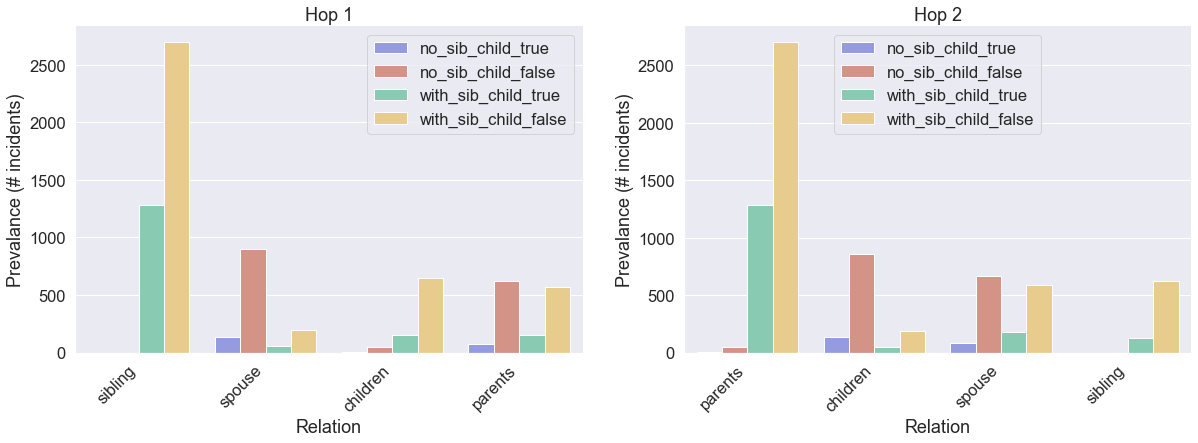

In [12]:
plt.figure(figsize=(20,6))

for idx, hop_num in enumerate([1,2]):
    plt.subplot(1,2,idx+1)
    ax = sns.barplot(x ='ex_rel', y="q_head", hue="cond",palette=pal,
        data = df[(df.path_type=='two_hop') & (df.hop==hop_num)].groupby(['cond', 'ex_rel']).count().sort_values(by=['cond']).sort_values(
            by=['coef'], ascending=False).reset_index(), hue_order = cond_order)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
    ax.set_ylabel('Prevalance (# incidents)')
    ax.set_xlabel('Relation')
    plt.legend(title='')
    ax.set_title(f"Hop {hop_num}")

sns.despine()

<Figure size 1440x576 with 0 Axes>

[Text(0, 0, 'children'),
 Text(0, 0, 'parents'),
 Text(0, 0, 'spouse'),
 Text(0, 0, 'sibling'),
 Text(0, 0, 'place_of_birth'),
 Text(0, 0, 'place_of_death'),
 Text(0, 0, 'location'),
 Text(0, 0, 'institution'),
 Text(0, 0, 'cause_of_death'),
 Text(0, 0, 'religion'),
 Text(0, 0, 'profession'),
 Text(0, 0, 'ethnicity'),
 Text(0, 0, 'nationality')]

Text(0, 0.5, 'Prevalance (# incidents)')

Text(0.5, 0, 'Relation')

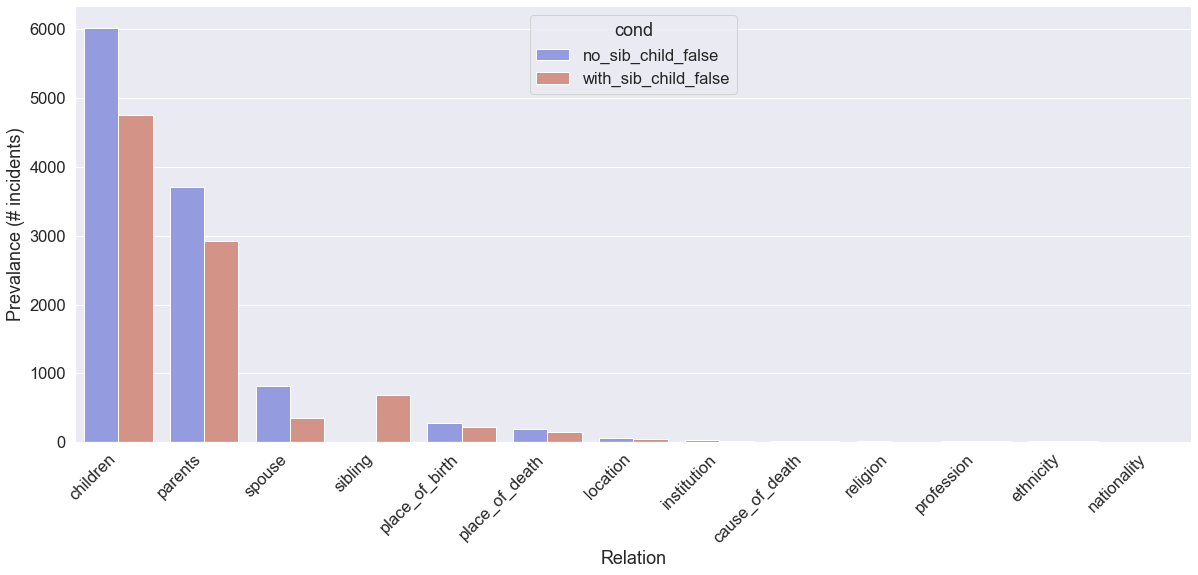

In [13]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x = "ex_rel", y="q_head", hue="cond",palette=pal,
    data = df[(df.path_type=='one_hop') & 
              (df.cond.isin(['no_sib_child_false','with_sib_child_false']))].groupby(
        ['cond','ex_rel']).count().sort_values(by=['cond']).sort_values(
        by=['coef'], ascending=False).reset_index(), hue_order = [cond_order[1],cond_order[3]])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('Prevalance (# incidents)')
ax.set_xlabel('Relation')

sns.despine()

##### What % of new hops that contain a lone child without completing triangle thats then actually a sibling of main child (query= [C1]-parents-[P1] and [P1]-children-[C2] shows up as an explanation, where [C1]-sibling-[C2])?

In [14]:
records = []
for qq in list(df[df.cond.isin(['no_sib_child_false'])].query_string.unique()):
    no_sib = df[(df.query_string==qq) & 
    (df.cond=='no_sib_child_false')].sort_values(by='coef', ascending=False).reset_index(drop=True)
    with_sib = df[(df.query_string==qq) & 
    (df.cond=='with_sib_child_false')].sort_values(by='coef', ascending=False).reset_index(drop=True)
    
    if not with_sib.empty:
        if no_sib.loc[0,'ex_rel']=='children':
            sib = no_sib.loc[0,'ex_tail']

        pred_bool = (with_sib.loc[0,'ex_head']==no_sib.loc[0,'ex_head'] and 
                 with_sib.loc[0,'ex_rel']==no_sib.loc[0,'ex_rel'] and
                 with_sib.loc[0,'ex_tail']==no_sib.loc[0,'ex_tail'])

        sib_bool = (with_sib.loc[1,'ex_head']== with_sib.loc[1,'q_head'] and
                 with_sib.loc[1,'ex_rel']=='sibling' and
                 with_sib.loc[1,'ex_tail']==sib)


        records.append({'query_string': qq,
         'same_top_pred': 1 if pred_bool else 0,
         'filled_in_sib': 1 if sib_bool else 0,
         'no_sib_coef': no_sib.loc[0,'coef'],
         'with_sib_coef': with_sib.loc[0,'coef'],
         'sib_coef': with_sib.loc[1,'coef']})

             
sib_switch = pd.DataFrame(records)

## Find pseudo-sibling relations in the split and full results

In [15]:
# pseudo_split = find_sibling_links_not_in_fb13(df_split[df_split.cond.isin(['no_sib_child_false', 'no_sib_child_true'])],
#                                         fb_13)

pseudo_full = find_sibling_links_not_in_fb13(df[df.cond.isin(['no_sib_child_false'])])

In [16]:
pseudo_full

,cond,query_string,q_head,q_rel,q_tail,path_type,hop,ex_head,ex_rel,ex_tail,coef,first_hop_score,path_score,split,link_exists
0,no_sib_child_false,anne_frank_has_parents_edith_frank_hollander,anne_frank,parents,edith_frank_hollander,one_hop,1,anne_frank,spouse,margot_frank,0.015121,0.768027,1.461134,0,0.0
1,no_sib_child_false,william_herbert_3rd_earl_of_pembroke_has_paren...,william_herbert_3rd_earl_of_pembroke,parents,henry_herbert_2nd_earl_of_pembroke,two_hop,2,philip_herbert_4th_earl_of_pembroke,spouse,william_herbert_3rd_earl_of_pembroke,0.073812,0.979394,3.028533,0,0.0
2,no_sib_child_false,josef_ferdinand_has_parents_alice_of_bourbon_p...,josef_ferdinand,parents,alice_of_bourbon_parma,one_hop,1,josef_ferdinand,spouse,archduchess_luise_princess_of_tuscany,0.015674,0.858766,1.957337,0,0.0
3,no_sib_child_false,frank_gilbreth_jr_has_parents_lillian_moller_g...,frank_gilbreth_jr,parents,lillian_moller_gilbreth,one_hop,1,frank_gilbreth_jr,spouse,ernestine_gilbreth_carey,0.048890,0.828768,1.764735,0,0.0
4,no_sib_child_false,anna_deste_has_parents_ercole_ii_deste,anna_deste,parents,ercole_ii_deste,two_hop,2,alfonso_ii_duke_of_ferrara,spouse,anna_deste,0.169677,0.980699,2.650512,0,0.0
5,no_sib_child_false,archduchess_luise_princess_of_tuscany_has_pare...,archduchess_luise_princess_of_tuscany,parents,alice_of_bourbon_parma,one_hop,1,archduchess_luise_princess_of_tuscany,spouse,josef_ferdinand,0.010480,0.851720,1.908653,0,0.0
6,no_sib_child_false,charles_of_valois_has_parents_isabella_of_aragon,charles_of_valois,parents,isabella_of_aragon,two_hop,2,philip_iv_of_france,spouse,charles_of_valois,0.025705,0.972073,2.476423,0,0.0
7,no_sib_child_false,harry_augustus_garfield_has_parents_james_garf...,harry_augustus_garfield,parents,james_garfield,two_hop,2,james_rudolph_garfield,spouse,harry_augustus_garfield,0.374822,0.978850,2.665868,0,0.0
8,no_sib_child_false,ferdinand_duke_of_parma_has_parents_philip_duk...,ferdinand_duke_of_parma,parents,philip_duke_of_parma,two_hop,2,isabella_maria_of_parma,spouse,ferdinand_duke_of_parma,0.130179,0.971448,2.714145,0,0.0
9,no_sib_child_false,gary_crosby_has_parents_dixie_lee,gary_crosby,parents,dixie_lee,two_hop,2,lindsay_crosby,spouse,gary_crosby,0.015466,0.968483,2.508114,0,0.0


In [17]:
sib_equiv = df_full[(df_full.cond.isin(['with_sib_child_false'])) & (df_full.query_string.isin(pseudo_full.query_string)) & 
                                                       (df_full.ex_rel=='sibling')]

In [18]:
records = []
for index, row in pseudo_full.iterrows():
    new_edge = sib_equiv[(sib_equiv.ex_head == row['ex_head']) & (sib_equiv.ex_tail == row['ex_tail'])]
    if not new_edge.empty:
        row['run_type']='FB13'
        row['ex_string']=row['ex_head'] + '_' + row['ex_rel'] + '_' + row['ex_tail'] 
        new_row = new_edge.to_dict(orient='records')[0]
        new_row['run_type']='FB14'

        
        records.append(row.to_dict())
        records.append(new_row)
pseudo_sib = pd.DataFrame(records)
    

<Figure size 1152x360 with 0 Axes>

(-0.7, 0.7)

(-1, 1)

Text(0.5, 0, 'FB13 children')

Text(0, 0.5, 'FB13 spouse')

Text(-1.2, 0.9, 'A')

(-0.7, 0.7)

(-1, 1)

Text(0.5, 0, 'FB14 children')

Text(0, 0.5, 'FB14 sibling')

Text(-1.2, 0.9, 'B')

(-0.7, 0.7)

(-1, 1)

Text(0.5, 0, 'FB14 spouse')

Text(0, 0.5, 'FB14 sibling')

Text(-1.2, 0.9, 'C')

[]

Text(0.5, 0, '')

(-0.1, 1.1)

[Text(0, 0, 'FB13'), Text(0, 0, 'FB14')]

Text(0, 0.5, 'linklogic coefficient')

Text(-1.2, 1.03, 'D')

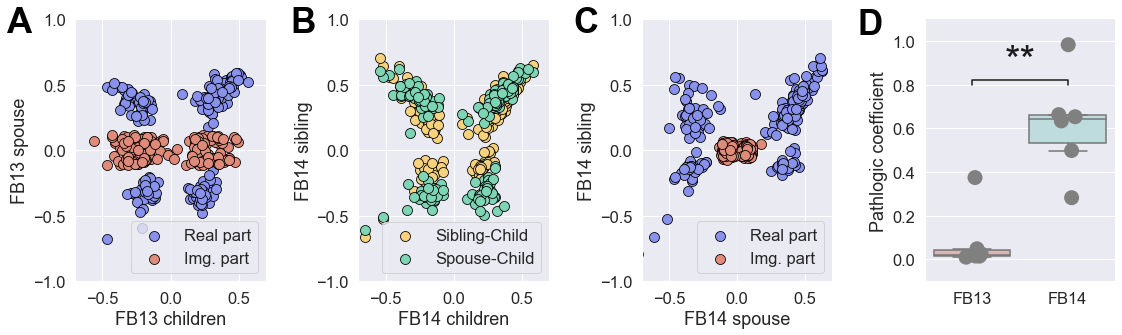

In [20]:
plt.figure(figsize=(16,5))

def add_stat_star(p_val):
    anot = "ns"
    if p_val < 0.001:
        anot = "***"
    elif p_val < 0.01:
        anot = "**"
    elif p_val < 0.05:
        anot = "*"
        
    x1, x2 = 0, 1 
    y, h, col = 0.8, 0.02, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, anot, ha='center', va='bottom', color=col, fontsize=40)


plt.subplot(1,4,1)
ax = sns.scatterplot(x=rel_emb_13[rel_id_13.loc[rel_id_13['rel']=='children','idx'].values[0]][:200],
               y=rel_emb_13[rel_id_13.loc[rel_id_13['rel']=='spouse','idx'].values[0]][:200], 
                     s=100, edgecolor = 'black', color=pal[0], label='Real part')
sns.scatterplot(x=rel_emb_13[rel_id_13.loc[rel_id_13['rel']=='children','idx'].values[0]][200:],
               y=rel_emb_13[rel_id_13.loc[rel_id_13['rel']=='spouse','idx'].values[0]][200:],
                s=100,  edgecolor = 'black', color=pal[1], label='Img. part')
ax.set_xlim([-0.7, 0.7])
ax.set_ylim([-1, 1])
ax.set_xlabel('FB13 children')
ax.set_ylabel('FB13 spouse')
plt.legend(loc='lower right')
plt.text(-1.2, 0.9,"A", color='black', fontweight='bold', fontsize=35)


plt.subplot(1,4,2)
ax = sns.scatterplot(x=rel_emb_14[rel_id_14.loc[rel_id_14['rel']=='children','idx'].values[0]][:200],
               y=rel_emb_14[rel_id_14.loc[rel_id_14['rel']=='sibling','idx'].values[0]][:200],
                s=100, edgecolor = 'black', color=pal[3],label='Sibling-Child')


ax = sns.scatterplot(x=rel_emb_14[rel_id_14.loc[rel_id_14['rel']=='children','idx'].values[0]][:200],
               y=rel_emb_14[rel_id_14.loc[rel_id_14['rel']=='spouse','idx'].values[0]][:200],
                s=100, edgecolor = 'black', color=pal[2],label='Spouse-Child')

ax.set_xlim([-0.7, 0.7])
ax.set_ylim([-1, 1])
plt.legend()
ax.set_xlabel('FB14 children')
ax.set_ylabel('FB14 sibling')
plt.legend(loc='lower right')
plt.text(-1.2, 0.9,"B", color='black', fontweight='bold', fontsize=35)

plt.subplot(1,4,3)
ax = sns.scatterplot(x=rel_emb_14[rel_id_14.loc[rel_id_14['rel']=='spouse','idx'].values[0]][:200],
               y=rel_emb_14[rel_id_14.loc[rel_id_14['rel']=='sibling','idx'].values[0]][:200],
                s=100, edgecolor = 'black', color=pal[0],label='Real part')
sns.scatterplot(x=rel_emb_14[rel_id_14.loc[rel_id_14['rel']=='spouse','idx'].values[0]][200:],
               y=rel_emb_14[rel_id_14.loc[rel_id_14['rel']=='sibling','idx'].values[0]][200:], 
                s=100, edgecolor = 'black', color=pal[1], label='Img. part')
ax.set_xlim([-0.7, 0.7])
ax.set_ylim([-1, 1])
plt.legend()
ax.set_xlabel('FB14 spouse')
ax.set_ylabel('FB14 sibling')
plt.legend(loc='lower right')
plt.text(-1.2, 0.9,"C", color='black', fontweight='bold', fontsize=35)
#plt.legend(loc=(1.05,0))

plt.subplot(1,4,4)
ax = sns.boxplot(x="run_type",y="coef", data=pseudo_sib, palette =[pal[4],pal[5]],showfliers=False)
tests = stats.mannwhitneyu(pseudo_sib[pseudo_sib.run_type=='FB13'].coef, pseudo_sib[pseudo_sib.run_type=='FB14'].coef)
add_stat_star(tests.pvalue)
sns.stripplot(x="run_type",y="coef", data=pseudo_sib, color='grey',s=15)
ax.set_xticklabels([])
sns.despine()
ax.set_xlabel('')
ax.set_ylim([-0.1,1.1])
ax.set_xticklabels(['FB13','FB14'])
ax.set_ylabel('linklogic coefficient')
plt.text(-1.2, 1.03,"D", color='black', fontweight='bold', fontsize=35)


# plt.subplot(2,3,6)
# ax = sns.boxplot(x="run_type",y="path_score", data=pseudo_sib, palette =[pal[4],pal[5]], showfliers=False)
# tests = stats.mannwhitneyu(pseudo_sib[pseudo_sib.run_type=='FB13'].path_score, 
#                            pseudo_sib[pseudo_sib.run_type=='FB14'].path_score)
# add_stat_star(tests.pvalue)

# x1, x2 = 0, 1 
# y, h, col = 4.1, 0.02, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, '**', ha='center', va='bottom', color=col, fontsize=40)

#sns.stripplot(x="run_type",y="path_score", data=pseudo_sib, color='grey',s=15)

# plt.legend(title='')
# ax.set_ylim([1,5])
# ax.set_xticklabels([])
# #plt.legend(loc=(1.05,0))
# ax.get_legend().remove()
# ax.set_xticklabels(['FB13','FB14'])
# sns.despine()
# ax.set_xlabel('')
# ax.set_ylabel('linklogic score')
plt.tight_layout()

plt.savefig('../../figures/submission_june_21/Experiment_3.png',bbox_inches='tight')

/Users/rhodos/.pyenv/versions/3.6.5/envs/akbc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/Users/rhodos/.pyenv/versions/3.6.5/envs/akbc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/Users/rhodos/.pyenv/versions/3.6.5/envs/akbc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


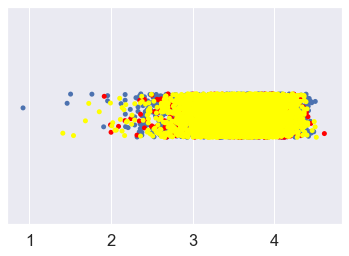

In [21]:
sns.stripplot(df[(df.ex_rel=='spouse') & (df.cond=='no_sib_child_false')].path_score.unique())
sns.stripplot(df[(df.ex_rel=='spouse') & (df.cond=='with_sib_child_false')].path_score.unique(), color='red')
sns.stripplot(df[(df.ex_rel=='sibling') & (df.cond=='with_sib_child_false')].path_score.unique(), color='yellow')

In [22]:
df_full[(df_full.cond=='no_sib_child_true') & (df_full.ex_rel=='children') & (df_full.path_type=='one_hop')].shape[0]

4086

In [23]:
df_full[(df_full.cond=='no_sib_child_true')].shape[0]

8378

In [24]:
child_used = []
child_coef = []
next_coef = []
for query_string in tqdm(list(df_full[(df_full.cond=='no_sib_child_true')].query_string.unique())):
    sub_df = df_full[(df_full.cond=='no_sib_child_true') & 
                     (df_full.query_string==query_string)].sort_values(by='coef', ascending=False).reset_index(drop=True)
    if sub_df.loc[0,'ex_rel']=='children' and sub_df.loc[0,'path_type']=='one_hop':
        child_used.append(1)
        child_coef.append(sub_df.loc[0,'coef'])
        if sub_df.shape[0]>1:
            next_coef.append(sub_df.loc[1,'coef'])
        else:
            next_coef.append(0)
    else:
        child_used.append(0)
    

  0%|          | 0/2294 [00:00<?, ?it/s]